<a href="https://colab.research.google.com/github/inachenyx/ECG_VO2/blob/main/ECGdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb

In [ ]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wfdb.processing import correct_peaks
from scipy.signal import resample

import matplotlib as mpl
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

In [ ]:
# Only fetch record 100 into Colab VM storage
wfdb.dl_database('mitdb', dl_dir='mitdb', records=['100'])

Generating record list for: 100
Generating list of all files for: 100
Finished downloading files


In [ ]:
# AAMI beat label remapping
aami_map = {
    'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'A': 'SVEB', 'a': 'SVEB', 'J': 'SVEB', 'S': 'SVEB',
    'V': 'VEB', 'E': 'VEB',
    'F': 'F'
}

def normalize_to_range(signal, target_min=0.0, target_max=0.6):
    """Min-max normalize signal to target range"""
    s_min = np.min(signal)
    s_max = np.max(signal)
    return (signal - s_min) / (s_max - s_min) * (target_max - target_min) + target_min

def load_and_process_record(record_name, window_duration_sec=0.556, target_fs=1800):
    """Load dataset, segment to 0.556s, up-sample to 1800Hz, normalize to 0-0.6V, remap labels"""
    record = wfdb.rdrecord(f'mitdb/{record_name}') # Record object
    ann = wfdb.rdann(f'mitdb/{record_name}', 'atr') # annotations

    original_fs = record.fs  # 360 Hz
    window_samples_original = int(window_duration_sec * original_fs)  # ~200 sample points (timesteps)
    target_length = int(window_duration_sec * target_fs)  # 1000 samples points (timesteps)

    signal = record.p_signal[:, 0]  # MLII channel physical signals
    beats, labels = [], []

    for i, sym in enumerate(ann.symbol):
        if sym not in aami_map:
            continue # skip current iteration and go on to next

        r = ann.sample[i] # time location in the ECG where R peak occurred
        start = r - window_samples_original // 2
        end = r + window_samples_original // 2

        if start < 0 or end >= len(signal):
            continue

        segment = signal[start:end]

        # Upsample from 360 Hz to 1800 Hz
        upsampled = resample(segment, target_length)

        # Normalize to 0–0.6 V range
        normalized = normalize_to_range(upsampled, 0.0, 0.6)

        beats.append(normalized)
        labels.append(aami_map[sym])

    return np.array(beats), np.array(labels)

In [ ]:
# Load all beats and labels from record no.100
beats, labels = load_and_process_record(100)
print(beats)
print(labels)
print("Beats:", beats.shape)
print("Label distribution:", np.unique(labels, return_counts=True))


[[0.08986661 0.09690342 0.10034163 ... 0.05404637 0.06708807 0.07956594]
 [0.08834295 0.09167342 0.09287398 ... 0.06895607 0.07623743 0.08300581]
 [0.11182345 0.11279041 0.11429427 ... 0.11105923 0.11120377 0.11136159]
 ...
 [0.12293997 0.12673961 0.12790966 ... 0.10017877 0.10874329 0.11670056]
 [0.12052636 0.12080399 0.1206945  ... 0.11818825 0.11908958 0.11991622]
 [0.12076431 0.12699357 0.1289404  ... 0.08260763 0.09715561 0.11045463]]
['N' 'N' 'N' ... 'N' 'N' 'N']
Beats: (2271, 1000)
Label distribution: (array(['N', 'SVEB', 'VEB'], dtype='<U4'), array([2237,   33,    1]))


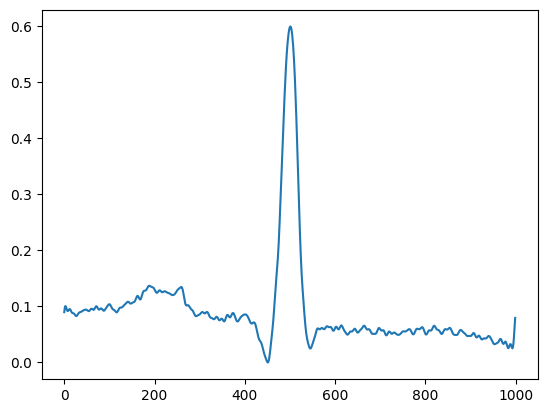

In [ ]:
plt.figure()
plt.plot(beats[0])
plt.show()

[0.08986661 0.09690342 0.10034163 ... 0.08165796 0.08339501 0.08518064]
[np.str_('N'), np.str_('N'), np.str_('N')]
y shape: (3000,)


Text(0, 0.5, 'y')

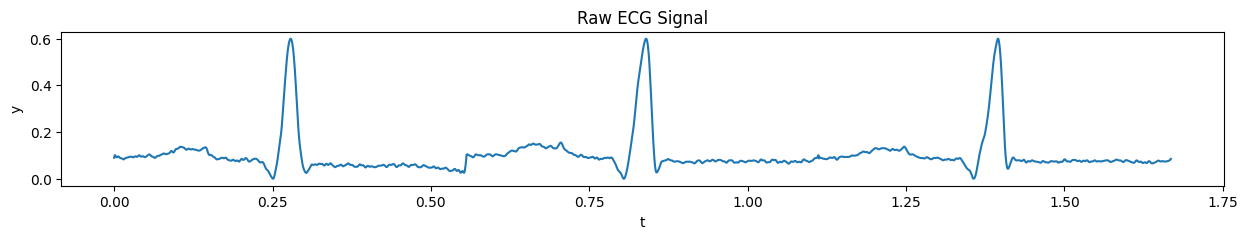

In [ ]:
bi = [0,600,1600] # beat index
y, l = [], []

for i in bi:
    y.append(beats[i])
    l.append(labels[i])

y = np.concatenate(y)
print(y)
print(l)
print("y shape:", y.shape)
n = len(y)
t = np.linspace(0, 0.556*3, n)

plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.title("Raw ECG Signal")
plt.xlabel("t")
plt.ylabel("y")

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'yt')

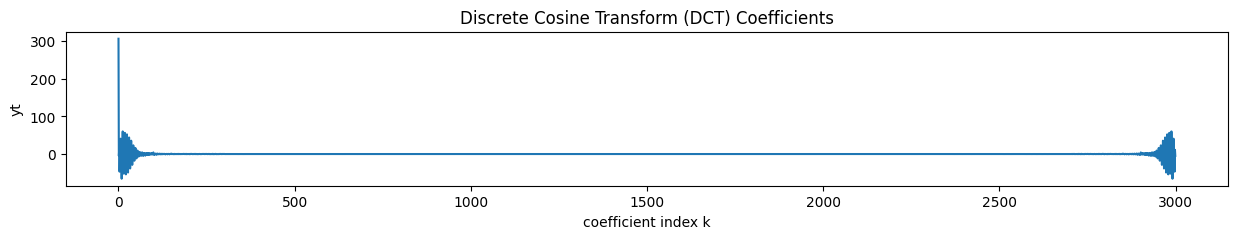

In [ ]:
yt = spfft.dct(y, norm='ortho')
yt = spfft.fft(y)

plt.figure(figsize=(15, 2))
plt.plot(yt)
plt.title("Discrete Cosine Transform (DCT) Coefficients")
plt.xlabel('coefficient index k')
plt.ylabel('yt')

Text(0, 0.5, 'y_samp')

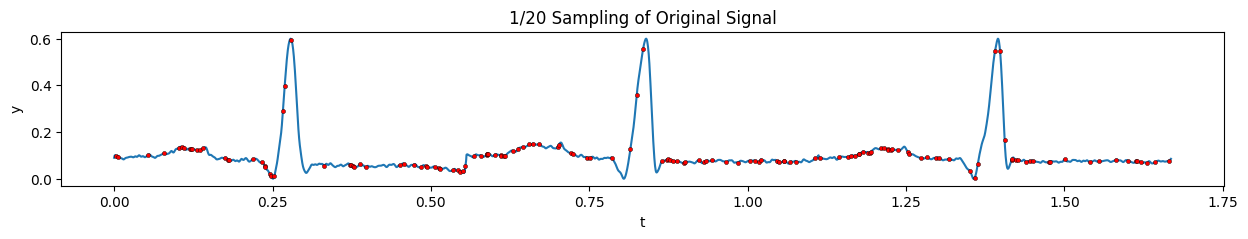

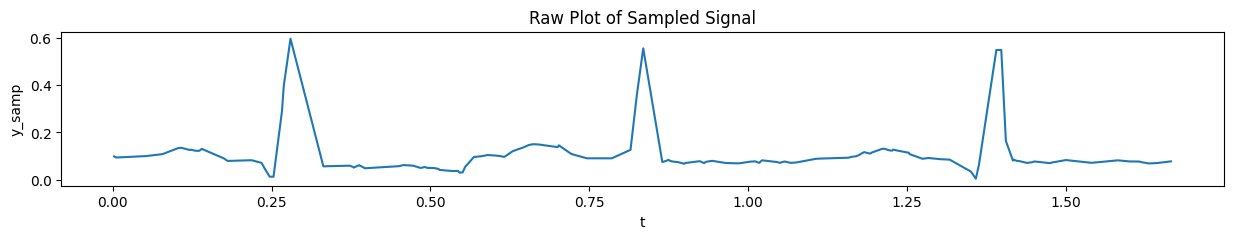

In [ ]:
# extract small sample of signal
m = int(n/20) # 1/20 sample
ri = np.random.choice(n, m, replace=False) # random sample of indices
ri.sort() # sorting not strictly necessary, but convenient for plotting
t2 = t[ri]
y2 = y[ri]

plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.plot(t2, y2, 'o', markersize=3, markerfacecolor='red', markeredgecolor='black', markeredgewidth=0.3)
plt.title('1/20 Sampling of Original Signal')
plt.xlabel('t')
plt.ylabel('y')

plt.figure(figsize=(15, 2))
plt.plot(t2, y2)
plt.title('Raw Plot of Sampled Signal')
plt.xlabel('t')
plt.ylabel('y_samp')

In [ ]:
# create idct matrix operator
A = spfft.idct(np.identity(n), norm='ortho', axis=0) # A: the inverse DCT matrix
print(A.shape)
A = A[ri]
print(A.shape)

(3000, 3000)
(150, 3000)


In [ ]:
# do L1 optimization
vx = cvx.Variable(n) # the DCT coeff vector to solve for
print(vx.shape)
objective = cvx.Minimize(cvx.norm(vx, 1)) # minimize L1 norm - promote sparsity
constraints = [A*vx == y2] # exactly match known sampled values
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True) # the optimal value of the objective function (L1 norm)

(3000,)
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 20 03:28:27 AM: Your problem has 3000 variables, 150 constraints, and 0 parameters.
(CVXPY) May 20 03:28:27 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 20 03:28:27 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 20 03:28:27 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 20 03:28:27 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 20 03:28:27 AM: Compiling problem (target solver

/usr/local/lib/python3.11/dist-packages/cvxpy/expressions/expression.py:674: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) May 20 03:28:28 AM: Applying reduction CLARABEL
(CVXPY) May 20 03:28:28 AM: Finished problem compilation (took 6.000e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) May 20 03:28:28 AM: Invoking solver CLARABEL  to obtain a solution.
-------------------------------------------------------------
           Clarabel.rs v0.10.0  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 6000
  constraints   = 6150
  nnz(P)        = 0
  nnz(A)        = 461928
  cones (total) = 2
    :        Zero = 1,  numel = 150
    : Nonnegative = 1,  numel = 6000

settings:
  linear algebra: direct 

Text(0, 0.5, 'y_samp')

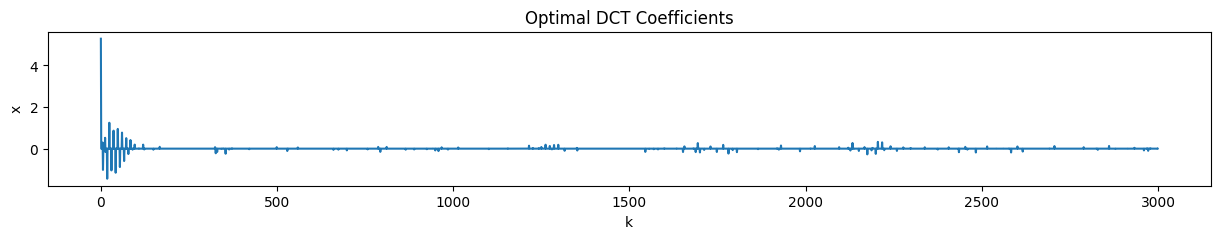

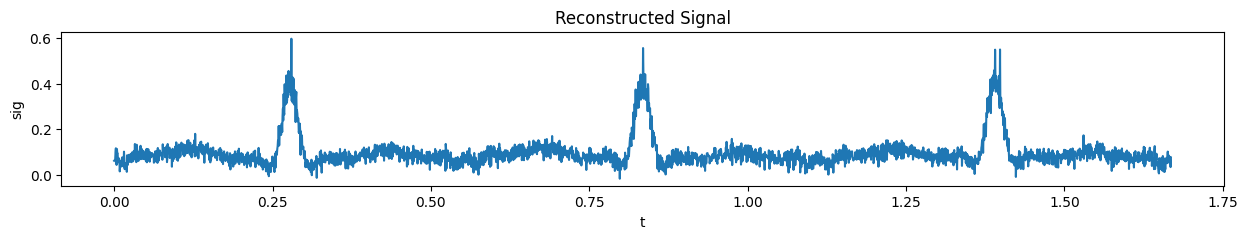

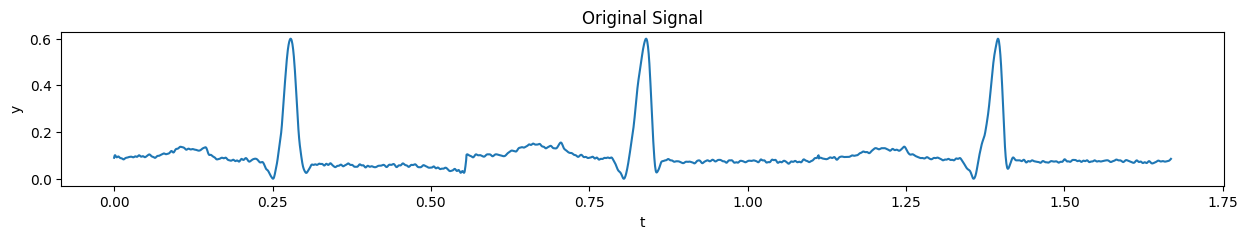

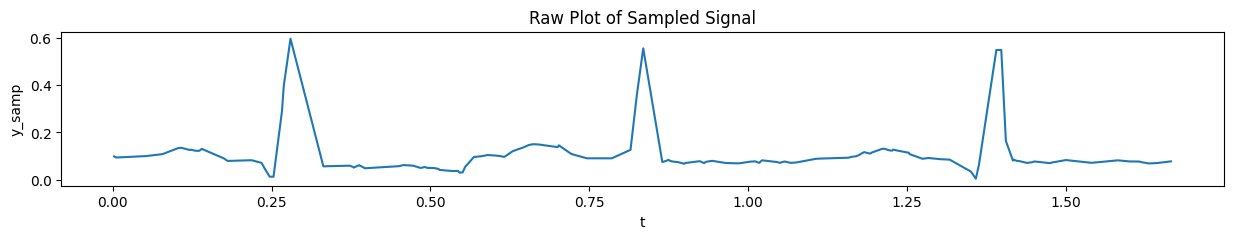

In [ ]:
# reconstruct signal
x = np.array(vx.value) # x: optimal DCT coefficients
x = np.squeeze(x) # clean up unnecessary dimensions
sig = spfft.idct(x, norm='ortho', axis=0) # inverse DCT (spectral > temporal domain)

plt.figure(figsize=(15, 2))
plt.plot(x)
plt.title("Optimal DCT Coefficients")
plt.xlabel('k')
plt.ylabel('x')
plt.figure(figsize=(15, 2))
plt.plot(t, sig)
plt.title("Reconstructed Signal")
plt.xlabel('t')
plt.ylabel('sig')
plt.figure(figsize=(15, 2))
plt.plot(t, y)
plt.title("Original Signal")
plt.xlabel('t')
plt.ylabel('y')
plt.figure(figsize=(15, 2))
plt.plot(t2, y2)
plt.title('Raw Plot of Sampled Signal')
plt.xlabel('t')
plt.ylabel('y_samp')

# Iterate through ids

In [ ]:
record_ids = ['100', '101']
X, y = [], []

for rec in record_ids:
    beats, labels = load_and_process_record(rec)
    X.append(beats)
    y.append(labels)

X = np.concatenate(X)
y = np.concatenate(y)

print("X shape:", X.shape)  # (num_beats, 1000)
print("Label distribution:", np.unique(y, return_counts=True))


In [ ]:
# Download record 100 from the MIT-BIH Arrhythmia Database
wfdb.dl_database('mitdb', dl_dir='mitdb', records=['100'])

# Load ECG record and annotations
record = wfdb.rdrecord('mitdb/100', sampto=650000)  # Choose appropriate length
annotation = wfdb.rdann('mitdb/100', 'atr')

# Set parameters
signal = record.p_signal[:, 0]  # Use MLII (channel 0)
sample_rate = record.fs         # Typically 360 Hz
window_size = 180               # 0.5 seconds before and after beat

# Extract Beat windows
X = []
y = []

for i, idx in enumerate(annotation.sample):
    # Ensure beat is not too close to start/end
    if idx - window_size < 0 or idx + window_size > len(signal):
        continue

    # Extract signal window
    beat = signal[idx - window_size : idx + window_size]

    # Label (use annotation symbol)
    label = annotation.symbol[i]

    X.append(beat)
    y.append(label)

In [ ]:
X = np.array(X)
y = np.array(y)

# Convert to DataFrame
df = pd.DataFrame(X)
df['label'] = y
# print(df)
print(y[1000:1015])